In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

In [24]:
# CUSTOMER id únic per cada línea de la taula (a priori no és útil), customer_unique_id client únic
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
# ORDER and PRODUCT relationship, with price, seller, shipping, etc.
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')

In [25]:
orders_customers_df = pd.merge(orders_df, customers_df, on='customer_id', how='left')
# a partir d'aquí estem a nivell de PRODUCTE comprat
df = pd.merge(order_items_df, orders_customers_df, on='order_id', how='left')
df = pd.merge(df, products_df, on='product_id', how='left')

# Translate product category names to English
translation_df = pd.read_csv('data/product_category_name_translation.csv')
translation_dict = dict(zip(translation_df["product_category_name"], translation_df["product_category_name_english"]))
df["product_category_name"] = df["product_category_name"].replace(translation_dict)

In [26]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date
# sports_leisure
# health_beauty
df = df[df["product_category_name"]== "health_beauty"]



In [27]:
spd_df = df.groupby('order_purchase').agg(
    num_purchases=('price', 'count'),
    avg_price=('price', 'mean')
).reset_index()

spd_df["order_purchase"] = pd.to_datetime(spd_df["order_purchase"])
spd_df = spd_df[(spd_df["order_purchase"]>"2018-01-01") & (spd_df["order_purchase"]<"2018-08-01")]

spd_df = spd_df.set_index("order_purchase")


In [28]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    # df['year'] = df.index.year
    # df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)  # 1 if Sat/Sun, else 0
    # df['is_black_friday'] = ((df.index.month == 11) & (df.index.day == 24)).astype(int)
    # df['post_2018'] = (df.index >= '2018-01-01').astype(int)


    return df

spd_df = create_features(spd_df)

def add_lags(df, col, lags=[1, 2, 3, 7, 14]):
    for lag in lags:
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df

spd_df = add_lags(spd_df, "num_purchases")
spd_df = add_lags(spd_df, "avg_price")

def add_rolling_features(df, col, windows=[3, 7, 14]):
    for window in windows:
        df[f"{col}_roll_mean_{window}"] = df[col].shift(1).rolling(window).mean()
    return df

spd_df = add_rolling_features(spd_df, "num_purchases")
spd_df = spd_df.dropna()
spd_df.shape

(197, 21)

In [29]:
spd_df.corr().style.background_gradient(cmap='coolwarm', axis=None)

,num_purchases,avg_price,dayofweek,quarter,month,dayofmonth,weekofyear,is_weekend,num_purchases_lag_1,num_purchases_lag_2,num_purchases_lag_3,num_purchases_lag_7,num_purchases_lag_14,avg_price_lag_1,avg_price_lag_2,avg_price_lag_3,avg_price_lag_7,avg_price_lag_14,num_purchases_roll_mean_3,num_purchases_roll_mean_7,num_purchases_roll_mean_14
num_purchases,1.000000,-0.050793,-0.400894,0.142297,0.196730,-0.180069,0.184983,-0.424649,0.482042,0.172431,0.032364,0.370592,0.110889,-0.140433,-0.034085,-0.000493,0.054570,0.074160,0.298969,0.383070,0.242965
avg_price,-0.050793,1.000000,-0.059222,0.024635,0.022171,-0.011406,0.022222,-0.086434,-0.038172,-0.156635,-0.155008,-0.130609,-0.037134,0.172669,0.180841,0.211748,-0.010583,-0.022601,-0.152135,-0.261310,-0.228398
dayofweek,-0.400894,-0.059222,1.000000,-0.008888,0.004693,-0.030040,-0.035147,0.790970,-0.148680,0.273877,0.371147,-0.391563,-0.380361,0.038527,0.078389,0.001930,-0.072490,-0.064314,0.215705,0.005303,0.005834
quarter,0.142297,0.024635,-0.008888,1.000000,0.917770,-0.055889,0.912927,0.008176,0.118600,0.110892,0.143053,0.164825,0.169276,0.015730,-0.012184,-0.039809,-0.095456,-0.099598,0.162023,0.257093,0.316221
month,0.196730,0.022171,0.004693,0.917770,1.000000,-0.097561,0.987406,0.012322,0.179150,0.174335,0.194317,0.187976,0.180835,0.040275,0.020814,0.017233,0.001576,0.009171,0.238267,0.330557,0.385019
dayofmonth,-0.180069,-0.011406,-0.030040,-0.055889,-0.097561,1.000000,0.056737,-0.008550,-0.102013,-0.051861,-0.047743,0.071893,0.184038,-0.101753,-0.040457,-0.101156,-0.073041,0.107989,-0.087716,0.004562,0.132099
weekofyear,0.184983,0.022222,-0.035147,0.912927,0.987406,0.056737,1.000000,-0.016725,0.170290,0.157896,0.174831,0.212844,0.221605,0.022845,0.011178,0.001018,-0.007454,0.027564,0.218791,0.332478,0.405252
is_weekend,-0.424649,-0.086434,0.790970,0.008176,0.012322,-0.008550,-0.016725,1.000000,-0.327109,0.052701,0.265396,-0.415682,-0.409932,0.024036,0.082529,-0.016395,-0.098707,-0.090393,-0.004212,0.002883,0.006020
num_purchases_lag_1,0.482042,-0.038172,-0.148680,0.118600,0.179150,-0.102013,0.170290,-0.327109,1.000000,0.479547,0.174816,0.311154,0.065220,-0.051235,-0.141646,-0.036503,0.090686,0.134115,0.720031,0.540826,0.372168
num_purchases_lag_2,0.172431,-0.156635,0.273877,0.110892,0.174335,-0.051861,0.157896,0.052701,0.479547,1.000000,0.487740,0.157995,-0.068267,-0.036339,-0.054788,-0.146081,0.063233,0.016671,0.856080,0.586157,0.436049


In [30]:
FEATURES = ['avg_price', 'dayofweek', 'month',
       'dayofmonth', #'is_weekend', # 'post_2018',
       'num_purchases_lag_3', 'num_purchases_lag_7', 'num_purchases_lag_14',
       #'num_purchases_lag_1', 'num_purchases_lag_2', 'num_purchases_lag_3',
       'avg_price_lag_1', 'avg_price_lag_2','avg_price_lag_3', 'avg_price_lag_7', 'avg_price_lag_14',
       'num_purchases_roll_mean_3', 'num_purchases_roll_mean_7','num_purchases_roll_mean_14'
       ]
TARGET = "num_purchases"

X = create_features(spd_df[FEATURES])
X = X[FEATURES]
y = spd_df[TARGET]





In [31]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {fold+1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Define a regularized XGBoost model
    reg = xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=3,
        min_child_weight=10,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=5,
        reg_alpha=0.5,
        reg_lambda=1.0,
        objective='reg:squarederror',
        early_stopping_rounds=50,
        random_state=42
    )

    reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")


Fold 1


[0]	validation_0-rmse:7.24515
[100]	validation_0-rmse:6.86415
[156]	validation_0-rmse:6.89160
Fold 1 RMSE: 6.8519

Fold 2
[0]	validation_0-rmse:6.60921
[100]	validation_0-rmse:6.30159
[133]	validation_0-rmse:6.30402
Fold 2 RMSE: 6.2885

Fold 3
[0]	validation_0-rmse:12.94406
[100]	validation_0-rmse:11.77727
[200]	validation_0-rmse:11.19737
[300]	validation_0-rmse:10.73477
[400]	validation_0-rmse:10.45000
[500]	validation_0-rmse:10.32535
[600]	validation_0-rmse:10.21590
[700]	validation_0-rmse:10.15461
[800]	validation_0-rmse:10.10035
[838]	validation_0-rmse:10.10246
Fold 3 RMSE: 10.0877

Fold 4
[0]	validation_0-rmse:10.86556
[100]	validation_0-rmse:8.57024
[200]	validation_0-rmse:7.87583
[300]	validation_0-rmse:7.73200
[400]	validation_0-rmse:7.70194
[469]	validation_0-rmse:7.68574
Fold 4 RMSE: 7.6788

Fold 5
[0]	validation_0-rmse:9.64315
[100]	validation_0-rmse:9.11759
[161]	validation_0-rmse:9.18648
Fold 5 RMSE: 9.1037


In [32]:
folds = [1, 2, 3, 4, 5]
rmses = [4.97, 4.34, 12.89, 6.74, 9.92]

# plt.plot(folds, rmses, marker='o')
# plt.title("RMSE per CV Fold")
# plt.xlabel("Fold")
# plt.ylabel("Validation RMSE")
# plt.grid(True)
# plt.show()

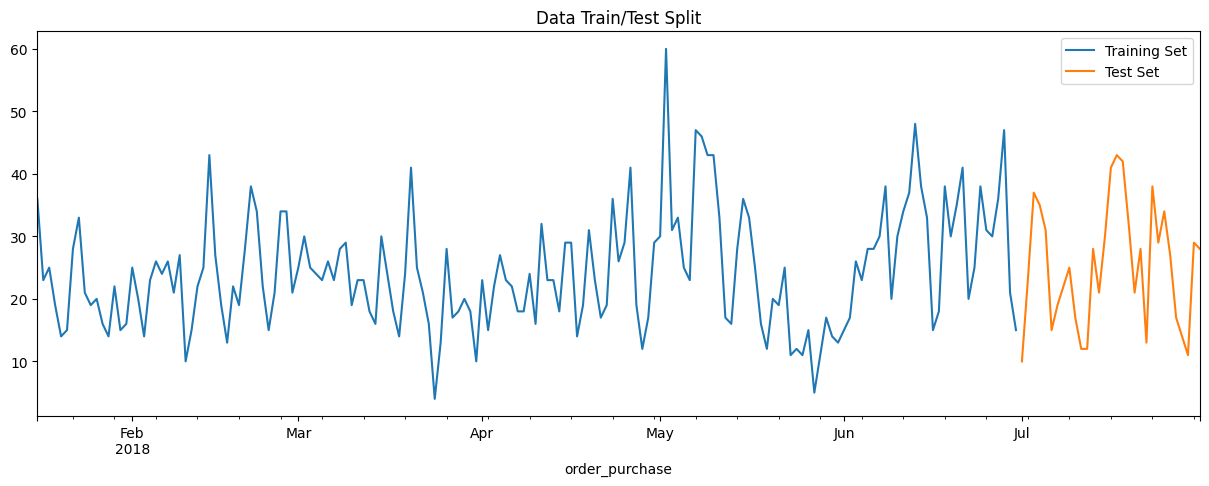

In [33]:
def train_test_split(data_X, data_y, date):
    X_train = data_X[data_X.index < date]
    X_test = data_X[data_X.index >= date]
    y_train = data_y[data_y.index < date]
    y_test = data_y[data_y.index >= date]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, "2018-07-01")

fig, ax = plt.subplots(figsize=(15, 5))
y_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
y_test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [34]:
reg = xgb.XGBRegressor(
    n_estimators=1000,              # More trees to allow slow learning
    learning_rate=0.01,             # Lower = smoother learning
    max_depth=5,                    # Limits complexity of each tree
    min_child_weight=10,            # Avoid small, specific leaf nodes
    gamma=5,                        # Only split if it improves loss enough
    subsample=0.7,                  # Use a subset of rows (bagging)
    colsample_bytree=0.7,           # Use a subset of features
    reg_alpha=0.5,                  # L1 regularization
    reg_lambda=1.0,                 # L2 regularization
    early_stopping_rounds=150,
    objective='reg:squarederror',
    random_state=42,
    verbosity=1
)


reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:9.15060	validation_1-rmse:9.65647
[100]	validation_0-rmse:6.48479	validation_1-rmse:9.29404
[200]	validation_0-rmse:5.10120	validation_1-rmse:9.54160
[231]	validation_0-rmse:4.79989	validation_1-rmse:9.67637


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=150,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

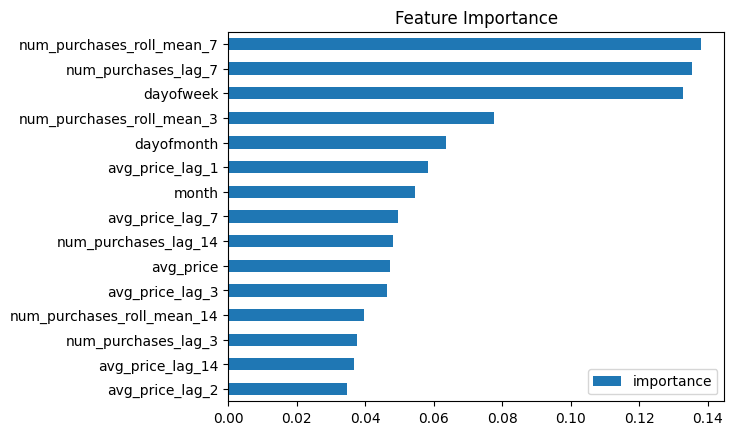

In [35]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

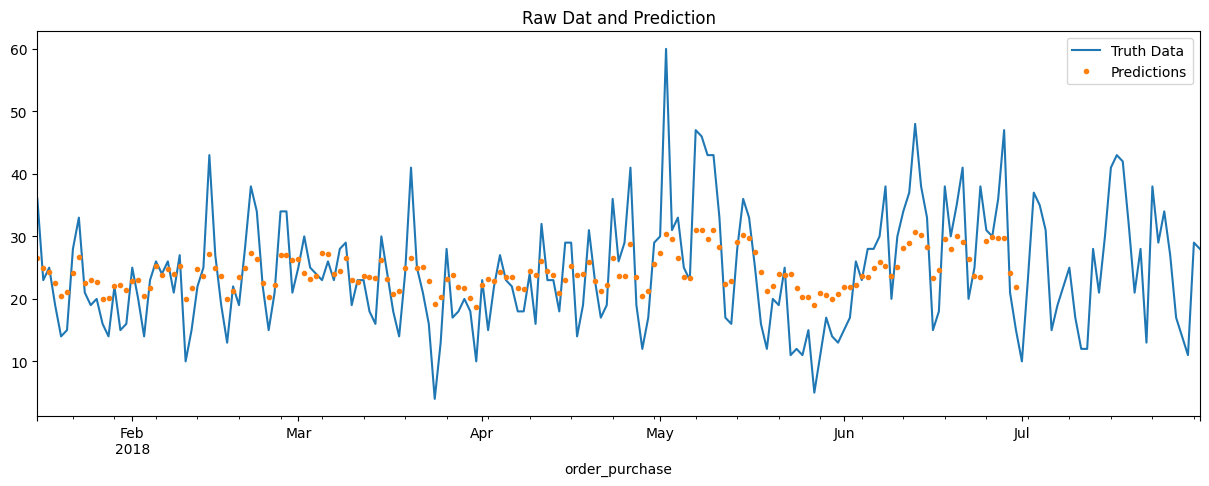

In [36]:
X_train_comp = X_train.copy()
X_train_comp["prediction"] = reg.predict(X_train_comp)
comp = pd.DataFrame({"Predictions": X_train_comp["prediction"],"Actual": y_train})# .plot(title="Train Predictions vs Actual", figsize=(15, 5))

ax = spd_df[['num_purchases']].plot(figsize=(15, 5))
comp['Predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


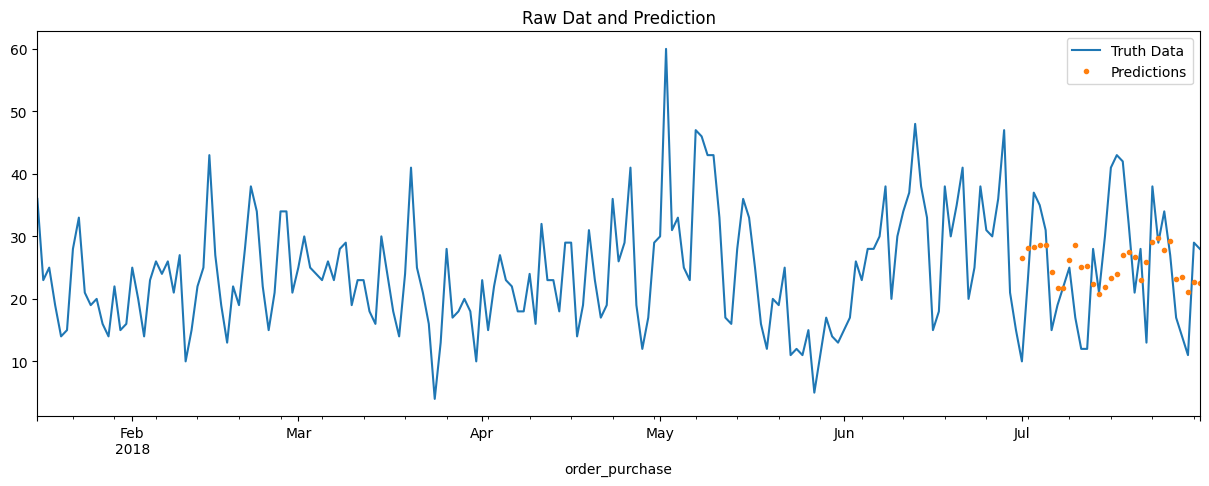

In [37]:
X_test_comp = X_test.copy()
X_test_comp["prediction"] = reg.predict(X_test_comp)
comp_test = pd.DataFrame({"Predictions": X_test_comp["prediction"],"Actual": y_test})# .plot(title="Train Predictions vs Actual", figsize=(15, 5))

ax = spd_df[['num_purchases']].plot(figsize=(15, 5))
comp_test['Predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

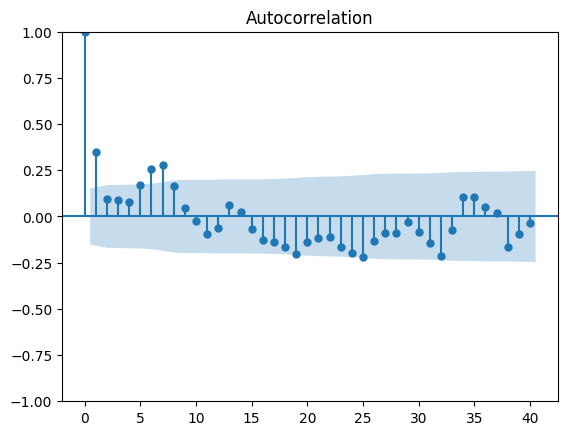

In [38]:
# to better evaluate fit, we can plot residuals
from statsmodels.graphics.tsaplots import plot_acf
comp["residuals"] = comp["Predictions"] - comp["Actual"]
plot_acf(comp["residuals"].dropna(), lags=40)
plt.show()

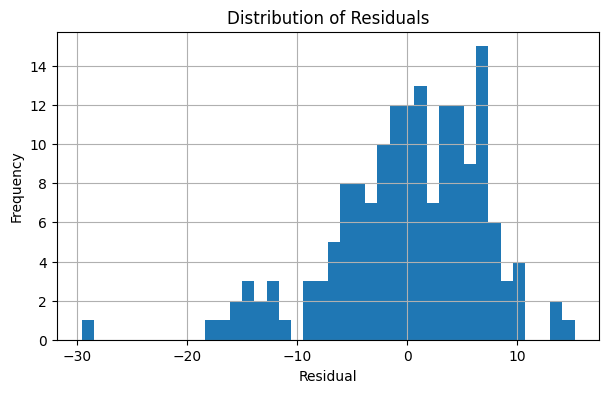

In [39]:
# Optional: Plot histogram of residuals
plt.figure(figsize=(7, 4))
comp["residuals"].hist(bins=40)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

## Price

In [40]:
price_columns = ["avg_price", "avg_price_lag_1", "avg_price_lag_2", "avg_price_lag_3", "avg_price_lag_7", "avg_price_lag_14"]
multipliers = list(np.arange(1, 2, 0.1))

X_test_price = X_test.copy()
num_purchases = []
income = []

for m in multipliers:
    X_test_price[price_columns] = X_test_price[price_columns] * m
    y_pred = reg.predict(X_test_price)

    num_purchases_value = y_pred.sum()
    num_purchases.append(num_purchases_value)

    income_value = (y_pred * X_test_price["avg_price"]).sum()
    income.append(income_value)
    
    print(f"Multiplier: {m:.1f}, Predicted Purchases: {num_purchases_value}, Income: {income_value}")


Multiplier: 1.0, Predicted Purchases: 785.0476684570312, Income: 104431.44283321149
Multiplier: 1.1, Predicted Purchases: 783.1632080078125, Income: 114562.33401094635
Multiplier: 1.2, Predicted Purchases: 778.62060546875, Income: 136496.33367853702
Multiplier: 1.3, Predicted Purchases: 769.683349609375, Income: 175411.4921430936
Multiplier: 1.4, Predicted Purchases: 765.8837280273438, Income: 244747.26852000595
Multiplier: 1.5, Predicted Purchases: 765.6504516601562, Income: 367012.18763537257
Multiplier: 1.6, Predicted Purchases: 765.6504516601562, Income: 587219.5002165962
Multiplier: 1.7, Predicted Purchases: 765.6504516601562, Income: 998273.1503682139
Multiplier: 1.8, Predicted Purchases: 765.6504516601562, Income: 1796891.6706627856
Multiplier: 1.9, Predicted Purchases: 765.6504516601562, Income: 3414094.174259294


In [41]:
# maximize the equation income = price * num_purchases
# and trying to maximize income, increasing price and not decreasing too much the purchases

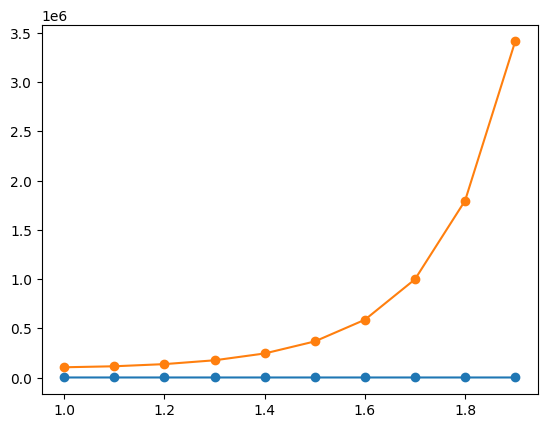

In [42]:
plt.plot(multipliers, num_purchases, marker='o')
plt.plot(multipliers, income, marker='o')

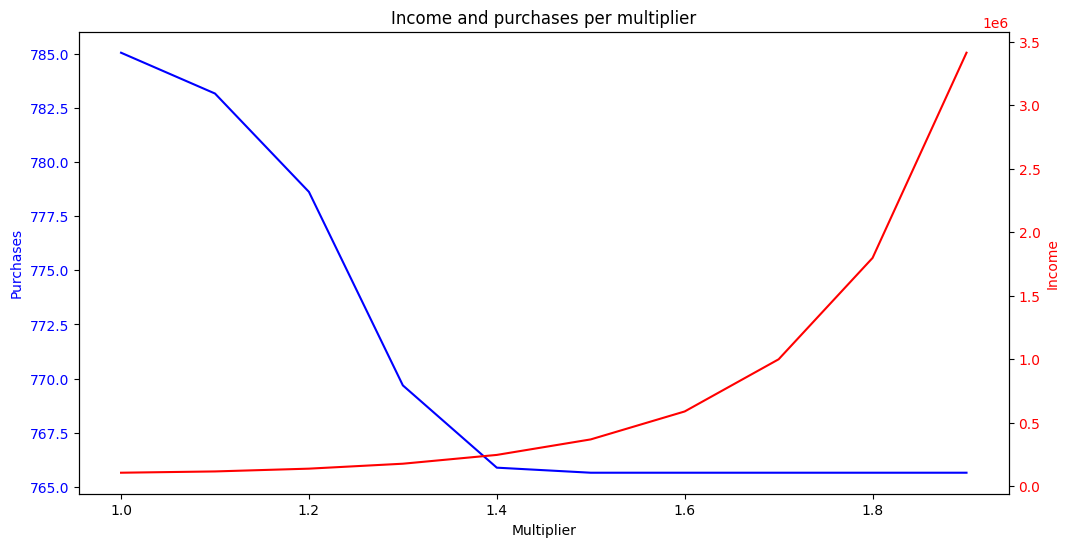

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(multipliers, num_purchases, color='blue', label='Purchases')
ax1.set_ylabel('Purchases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(multipliers, income, color='red', label='Income')
ax2.set_ylabel('Income', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Income and purchases per multiplier')
ax1.set_xlabel('Multiplier')

plt.show()